In [1]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from myheatmap import myheatmap
import matplotlib as mpl
import scipy as sp

#savefolder = '/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports'
savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'


print(mpl.__version__) # version 3 required for cmap='twilight_shifted'

sns.set_context('poster') # makes text larger

add_circle = True
plot3d = False


# colormaps: PiYG, vlag_r, bwr_r, RdBu, Seismic_r
divergingcmap = 'PiYG'
cmapforhalf = 'PiYG_r'


# source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))


3.1.2


In [2]:
### settings for adding grid of circles
pitch = 3.0 # 3 um from one peg to the next
rotationdegrees = -339 # 339 degrees of rotation from straight
radius = .55 # radius of circles to draw

xstart = -5.75 
ystart = 10.3

rotation = rotationdegrees * np.pi / (180)
deltax = pitch * np.cos(rotation)
deltay = pitch * np.sin(rotation)

# create grid about origin
xlist = [i*pitch for i in range(-3,6)]
ylist = [i*pitch for i in range(-6,4)]
#display(xlist)

"""    grid = np.meshgrid(xlist,ylist)
print(grid)"""

# rotate grid

# Generate a meshgrid and rotate it by RotRad radians.
# source: https://stackoverflow.com/questions/29708840/rotate-meshgrid-with-numpy
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

rotated = DoRotation(xlist,ylist, RotRad=rotation)
#display(rotated)

# translate grid to xstart and ystart
rottrans = rotated.copy()
rottrans[0] = rotated[0]+xstart
rottrans[1] = rotated[1]+ystart

#display(rottrans)

# create tuple list

xs = (rottrans[0]).flatten()
ys = (rottrans[1]).flatten()
coordlist = []
for i in range(len(xs)):
    coordlist.append((xs[i], ys[i]))

#display(coordlist)
len(coordlist)

coordlist.remove((-4.024362569144298, 6.424154871872494))
coordlist.remove((-0.7990510232365908, 14.826378710347306))

len(coordlist)
#display(coordlist)




88

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


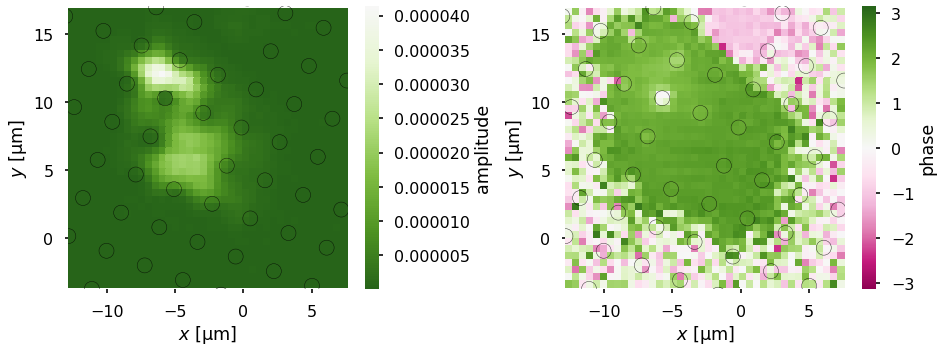

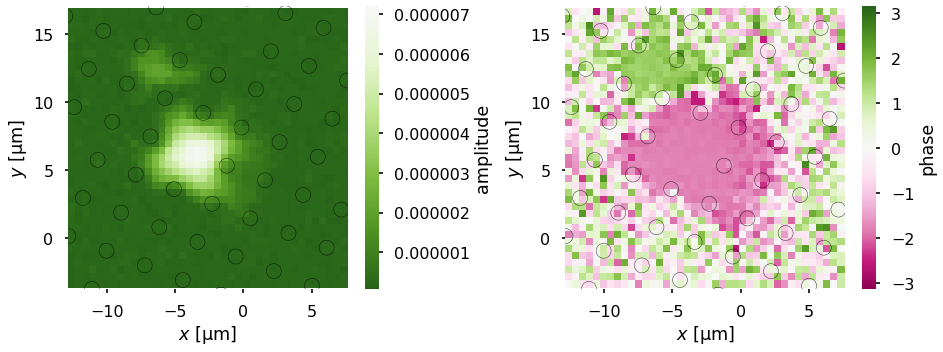

In [3]:
############### Mac vs Windows ##############
#folder1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/2019/08/09/'
#folder2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/07/30/'
folder1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\2019\08\09'
folder2 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\07\30'

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = (amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = amp2
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.sca(ax4) 
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
def add_sizebar(ax, size):
    asb = AnchoredSizeBar(ax.transData,
                          size,
                          str(size) + u' μm',
                          loc='lower right',
                          #bbox_to_anchor=(.5,.5),
                          size_vertical=.4,
                          pad=0.1, borderpad=0.5, sep=5,
                          frameon=False)
    ax.add_artist(asb)

    ## uncommenting the following line will create a sizebar a little bit covering the plot
#add_sizebar(ax4, 10)

plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:158: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:158: Run

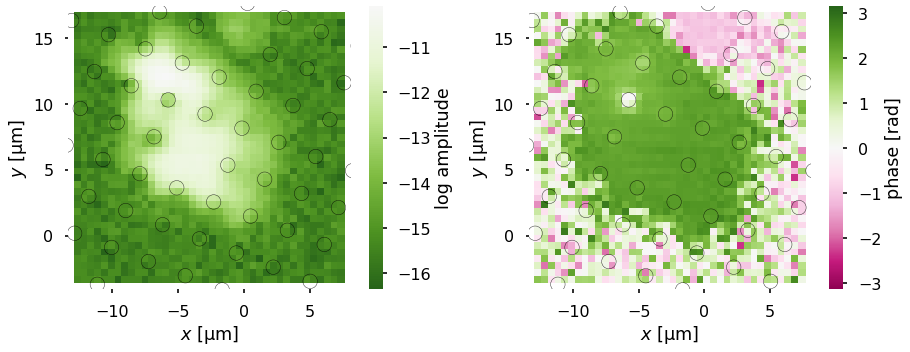

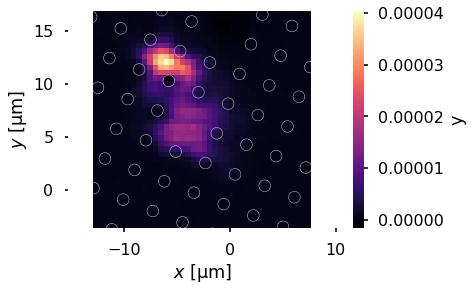

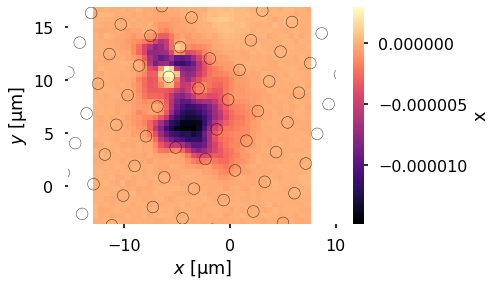

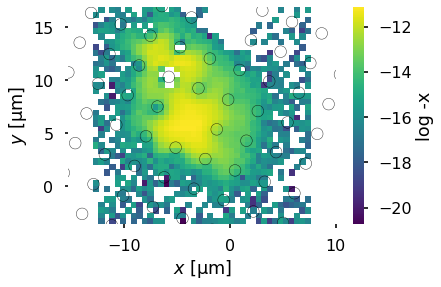

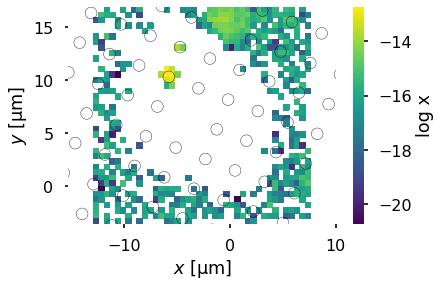

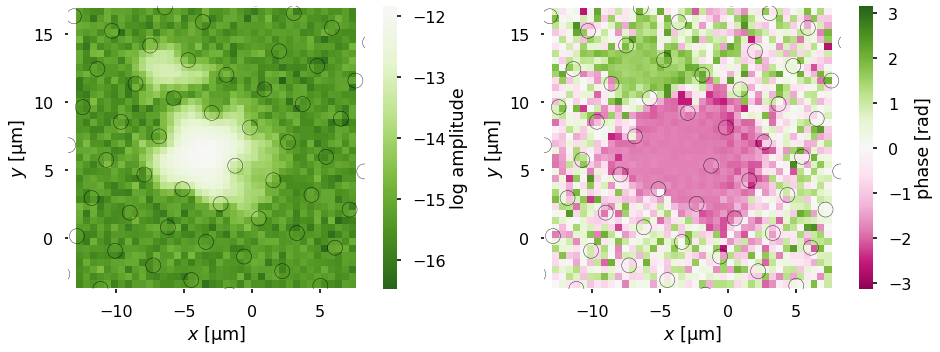

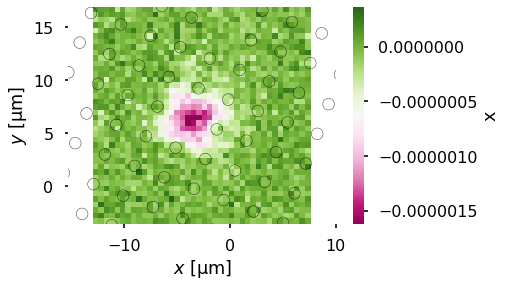

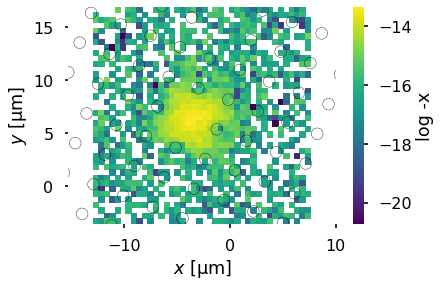

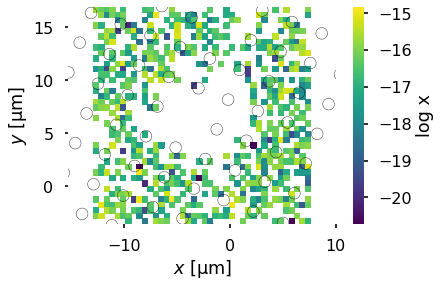

In [4]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase [rad]', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
plt.tight_layout();

plt.figure()
y1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'y').sort_index(axis = 0, ascending = False) 

myheatmap(y1, 'y') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(-x1), 'log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp2)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase [rad]',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.tight_layout();

plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(-x1), 'log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


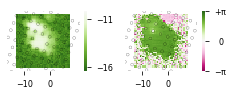

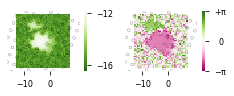

In [5]:
sns.set_context('paper') # makes text sized for paper

# pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

saving = True
add_circle= True

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']

sty={'figsize':(3.37,1.43)}

fig, (ax1, ax2) = plt.subplots(1, 2, **sty)

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

axx,cbar = myheatmap(data,  norm = greennorm, return_cbar=True,
          cmap=cmapforhalf);
plt.xlabel('')
plt.ylabel('')
ax1.axis('equal')
plt.xticks([-10,0])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

# decrease number of ticks on colorbar
"""tick_locator = mpl.ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()"""
cbar.set_ticks([-11, -16])

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
axx, cbar = myheatmap(phase1, return_cbar=True,  vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xticks([-10,0])
plt.xlabel('')
plt.ylabel('')
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.set_yticklabels(['$-$\u03C0', '  0', '$+$\u03C0'])  # make sure this line is joined with the one above it.
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.tight_layout();
if saving:
    plt.savefig(os.path.join(savefolder,file + '.pdf'), dpi=None, facecolor='w', edgecolor='w',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        metadata=None)



file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']


fig, (ax3, ax4) = plt.subplots(1, 2, **sty)

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp2)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

axx, cbar = myheatmap(data,  norm = greennorm, return_cbar=True,
          cmap=cmapforhalf);
plt.xlabel('')
plt.ylabel('')
ax3.axis('equal');
plt.xticks([-10,0])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

# decrease number of ticks on colorbar
#cbar.ax.locator_params(nbins=2)
cbar.set_ticks([-12,-16])

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
axx, cbar = myheatmap(phase2, return_cbar=True, vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel('')
plt.ylabel('')
ax4.axis('equal');
plt.xticks([-10,0])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.set_yticklabels(['$-$\u03C0', '  0', '$+$\u03C0'])  # make sure this line is joined with the one above it.

# add_sizebar(ax4, 10) # creates a scalebar a little bit covering the plot.

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.tight_layout();

if saving:
    plt.savefig(os.path.join(savefolder,file + '.pdf'), dpi=None, facecolor='w', edgecolor='w',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        metadata=None)

sns.set_context('poster') # makes text larger again

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238


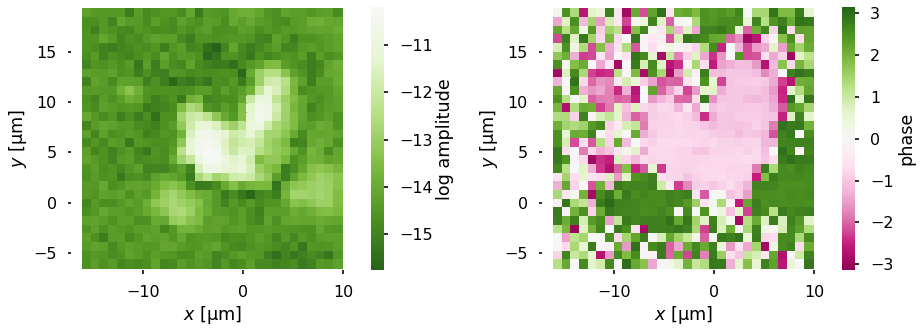

In [6]:
file = 'PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238' 
path = os.path.join(folder2,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

print(file)
plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238


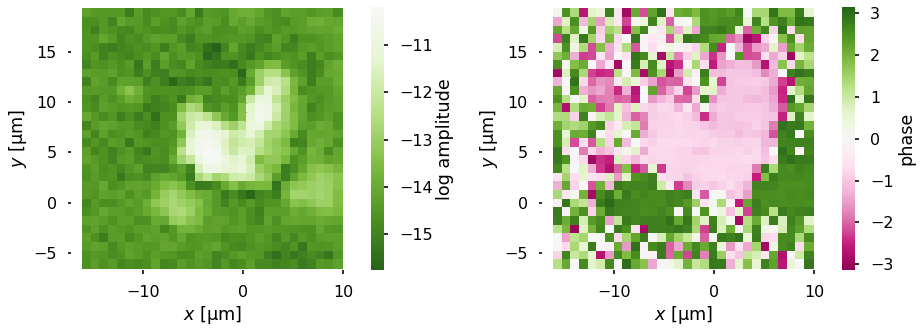

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

print(file)
plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


'plt.figure()\nmyheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))'

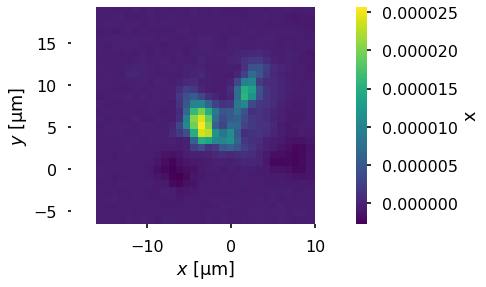

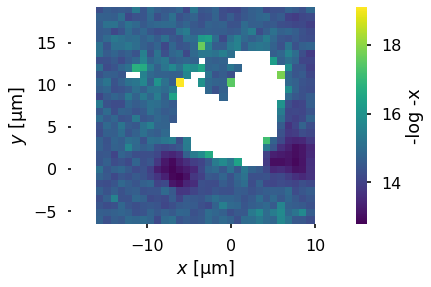

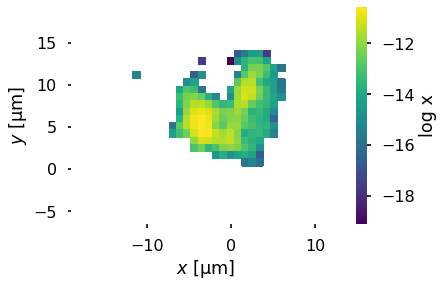

In [8]:
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(-np.log(-x1), '-log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

"""plt.figure()
myheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))"""

In [9]:
#np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))

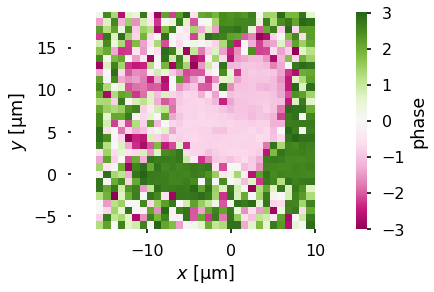

In [10]:

    
# set midpoint at zero.
vmin = np.array(phase1).min()
vmax = np.array(phase1).max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)


## Plot with a norm at 0
myheatmap(phase1, 'phase', norm = norm,
          cmap=divergingcmap);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

In [11]:
if plot3d:
    from mpl_toolkits import mplot3d
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(phase1.columns,phase1.index )
    ax.plot_surface(X,Y,phase1, 
                    norm=norm,  # set midpoint at 0.
                    antialiased=False,
                    cmap=divergingcmap )
    plt.xlabel(phase1.columns.name)
    plt.ylabel(phase1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


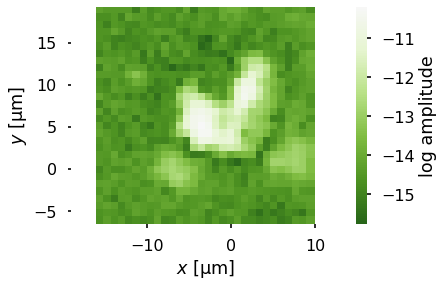

In [12]:
## Cut colorbar in half.

data = np.log(amp1)

# set white at max.
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)


## Plot with a midpoint at 0.
myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

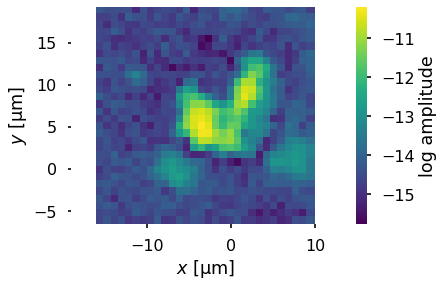

In [13]:
myheatmap(np.log(amp1), 'log amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if plot3d:
    plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(amp1.columns,amp1.index )
    ax.plot_surface(X,Y,(amp1), 
                    antialiased=False,
                    cmap='viridis', )
    plt.xlabel(amp1.columns.name)
    plt.ylabel(amp1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

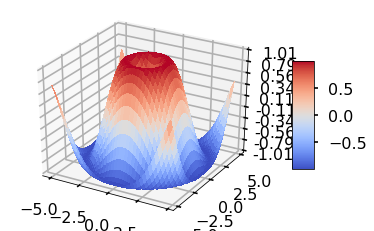

In [14]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()